In [2]:
pip install Cython numpy

   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.8 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.8 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.8 MB 903.6 kB/s eta 0:00:03
   ----------- ---------------------------- 0.8/2.8 MB 868.7 kB/s eta 0:00:03
   ----------- ---------------------------- 0.8/2.8 MB 868.7 kB/s eta 0:00:03
   ------------------- -------------------- 1.3/2.8 MB 1.0 MB/s eta 0:00:02
   -------------------------- ------------- 1.8/2.8 MB 1.3 MB/s eta 0:00:01
   ---------------------------------- ----- 2.4/2.8 MB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 1.6 MB/s  0:00:01
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install madmom librosa numpy pandas matplotlib tensorflow scikit-learn

  Using cached madmom-0.16.1.tar.gz (20.0 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached mido-1.3.3-py3-none-any.whl.metadata (6.4 kB)
Using cached mido-1.3.3-py3-none-any.whl (54 kB)
  Created wheel for madmom: filename=madmom-0.16.1-cp313-cp313-win_amd64.whl size=19981815 sha256=544719ea9bbefdf1d5057b2c9c12a837a5a402015db592f21f43f948769aa068
  Stored in directory: c:\users\aline\appdata\local\pip\cache\wheels\2e\d4\9b\eda4903ed8119f4035f24c302993656f4554a35d52b9f1ea6d
Successfully built madmom

   ---------------------------------------- 0/2 [mido]
   ---------------------------------------- 0/2 [mido]
   ---------------------------------------- 0/2 [mido]
   -------------------- ------------------- 1/2 [madmom]
   -------------------- ------------------- 1/2 [madmom]
   -------------------- ------------------- 1/2 [madmom]
   ---------------------------------------- 2/2 [madmom]



  DEPRECATION: Building 'madmom' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'madmom'. Discussion can be found at https://github.com/pypa/pip/issues/6334

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import numpy as np
import collections
import collections.abc

# --- CORREÇÃO DE COMPATIBILIDADE (Monkey Patch) ---

# --- CORREÇÃO 1: Numpy 2.0 vs Madmom ---
# O Numpy 2.0 removeu np.float e np.int, mas o Madmom precisa deles.
# Nós reinjetamos esses tipos manualmente.
if not hasattr(np, 'float'):
    np.float = float
if not hasattr(np, 'int'):
    np.int = int
if not hasattr(np, 'bool'): # Madmom as vezes usa np.bool também
    np.bool = bool

# --- CORREÇÃO 2: Python 3.10+ vs Madmom ---
# O madmom tenta buscar MutableSequence em 'collections', mas no Python 3.10+
# ele foi movido para 'collections.abc'. Esta linha corrige o redirecionamento.
collections.MutableSequence = collections.abc.MutableSequence
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.Sequence = collections.abc.Sequence
# --------------------------------------------------

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras.models import load_model
from madmom.audio.chroma import DeepChromaProcessor # Import do Madmom

SR = 44100
FFT_SIZE = 8192
HOP_SIZE = 4410
FPS = SR / HOP_SIZE
CONTEXT_W = 7
FMIN = 30
N_BINS = 178
BINS_OCTAVE = 24

AUDIO_DIR = '../SWD/audio_wav' 
ANNOT_DIR = '../SWD/ann_audio_chord'
MODEL_PATH = 'schubert_deep_chroma.keras' 

In [9]:
# 1. Função de Pré-processamento (Spectrograma Quarter-tone)
def compute_log_spectrogram(audio_path):
    y, sr = librosa.load(audio_path, sr=SR, mono=True)
    # VQT para simular o filtro logarítmico do artigo
    cqt = np.abs(librosa.vqt(y, sr=sr, hop_length=HOP_SIZE, 
                             fmin=FMIN, n_bins=N_BINS, 
                             bins_per_octave=BINS_OCTAVE))
    return np.log1p(cqt).T

# 2. Função de Labels (Target)
def get_chroma_target(chord_label):
    # Mapeamento simplificado
    notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    note_map = {n: i for i, n in enumerate(notes)}
    alias = {'Db':'C#', 'Eb':'D#', 'Gb':'F#', 'Ab':'G#', 'Bb':'A#'}
    
    target = np.zeros(12)
    if chord_label in ['N', 'N:N', 'silence']: return target
    
    try:
        if ':' in chord_label: root, quality = chord_label.split(':')
        else: root, quality = chord_label, 'maj'
        root = alias.get(root, root)
        if root not in note_map: return target
        
        root_idx = note_map[root]
        if 'min' in quality: intervals = [0, 3, 7]
        elif 'dim' in quality: intervals = [0, 3, 6]
        else: intervals = [0, 4, 7]
            
        for iv in intervals: target[(root_idx + iv) % 12] = 1.0
    except: pass
    return target

In [14]:
def extract_all_features_comparison(file_list, audio_dir, annot_dir, model):
    dcp = DeepChromaProcessor() 
    
    data = {'C': [], 'C_log': [], 'Madmom': [], 'Deep': [], 'y_plot': []}
    
    print(f"Extraindo features de {len(file_list)} arquivos...")
    
    for fname in file_list:
        a_path = os.path.join(audio_dir, fname + '.wav')
        l_path = os.path.join(annot_dir, fname + '.csv')
        
        if not os.path.exists(a_path) or not os.path.exists(l_path): 
            print(f"Arquivo não encontrado: {fname}")
            continue

        # 1. CARREGAR ÁUDIO
        try:
            y_audio, sr = librosa.load(a_path, sr=SR)
        except Exception as e:
            print(f"Erro ao ler áudio {fname}: {e}")
            continue

        total_frames = int(len(y_audio) / HOP_SIZE) + 1
        
        # --- 2. MADMOM (Passando o sinal carregado pelo Librosa) ---
        try:
            chroma_madmom = dcp(y_audio)
            
            # Ajuste de tamanho
            if chroma_madmom.shape[0] > total_frames: 
                chroma_madmom = chroma_madmom[:total_frames]
            elif chroma_madmom.shape[0] < total_frames:
                pad = total_frames - chroma_madmom.shape[0]
                chroma_madmom = np.pad(chroma_madmom, ((0, pad), (0, 0)))
            data['Madmom'].append(chroma_madmom)
        except Exception as e: 
            print(f"Erro no Madmom para {fname}: {e}")
            data['Madmom'].append(np.zeros((total_frames, 12)))

        # --- 3. GROUND TRUTH ---
        targets = np.zeros((total_frames, 12))
        try:
            df = pd.read_csv(l_path, sep=';') 
            
            for _, row in df.iterrows():
                try:
                    s = int(float(row.iloc[0]) * FPS)
                    e = int(float(row.iloc[1]) * FPS)
                    label = str(row.iloc[2]).replace('"', '') # Remove aspas extras se houver
                    
                    chroma = get_chroma_target(label)
                    if s < e: 
                        targets[max(0, s):min(total_frames, e)] = chroma
                except ValueError:
                    continue
        except Exception as e: 
            print(f"Erro ao ler CSV {fname}: {e}")
            pass
            
        data['y_plot'].append(targets)
        
        # --- 4. LIBROSA ---
        c_std = librosa.feature.chroma_cqt(y=y_audio, sr=sr, hop_length=HOP_SIZE).T
        data['C'].append(c_std[:total_frames])
        
        c_cq = librosa.cqt(y=y_audio, sr=sr, hop_length=HOP_SIZE, n_bins=84)
        c_log = librosa.filters.cq_to_chroma(84).dot(np.log1p(np.abs(c_cq))).T
        data['C_log'].append(c_log[:total_frames])
        
        # --- 5. MODELO TREINADO COM A BASE SWD ---
        # Recalcula spectrograma 
        cqt_input = np.abs(librosa.vqt(y_audio, sr=sr, hop_length=HOP_SIZE, 
                                     fmin=FMIN, n_bins=N_BINS, 
                                     bins_per_octave=BINS_OCTAVE))
        s_log = np.log1p(cqt_input).T
        
        spec_padded = np.pad(s_log, ((CONTEXT_W, CONTEXT_W), (0, 0)), mode='constant')
        windows = [spec_padded[i : i + (2*CONTEXT_W + 1)].flatten() for i in range(min(total_frames, s_log.shape[0]))]
        
        if len(windows) > 0:
            pred = model.predict(np.array(windows), verbose=0, batch_size=512)
            data['Deep'].append(pred)
        else:
            data['Deep'].append(np.zeros((total_frames, 12)))

    # Concatenação final
    final = {}
    for k in data:
        if len(data[k]) > 0: 
            final[k] = np.vstack(data[k])
        else:
            print(f"Aviso: Nenhum dado extraído para {k}")
            
    # Alinhamento
    if len(final) > 0:
        min_len = min([len(final[k]) for k in final])
        for k in final: final[k] = final[k][:min_len]
        
    return final
    return final

In [15]:
def plot_ultimate_comparison(results, start=500, duration=200):
    end = start + duration
    slices = {k: results[k][start:end].T for k in results}
    
    fig, ax = plt.subplots(5, 1, figsize=(12, 18), sharex=True)
    notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    
    # 1. Ground Truth
    ax[0].imshow(slices['y_plot'], aspect='auto', cmap='gray_r', origin='lower', vmin=0, vmax=1)
    ax[0].set_title("Ground Truth (Anotação)")
    
    # 2. Librosa
    ax[1].imshow(slices['C'], aspect='auto', cmap='gray_r', origin='lower')
    ax[1].set_title("Baseline: Librosa CQT")
    
    # 3. Log Librosa
    ax[2].imshow(slices['C_log'], aspect='auto', cmap='gray_r', origin='lower')
    ax[2].set_title("Baseline: Log-CQT")
    
    # 4. Madmom
    ax[3].imshow(slices['Madmom'], aspect='auto', cmap='gray_r', origin='lower', vmin=0, vmax=1)
    ax[3].set_title("Madmom")
    
    # 5. Seu Modelo
    ax[4].imshow(slices['Deep'], aspect='auto', cmap='gray_r', origin='lower', vmin=0, vmax=1)
    ax[4].set_title("Modelo (Treinado em Schubert)")
    ax[4].set_xlabel("Frames")
    
    for a in ax:
        a.set_yticks(range(12))
        a.set_yticklabels(notes)
        a.set_ylabel("Notas")
        
    plt.tight_layout()
    plt.show()

Carregando modelo de: schubert_deep_chroma.keras
Extraindo features de 4 arquivos...


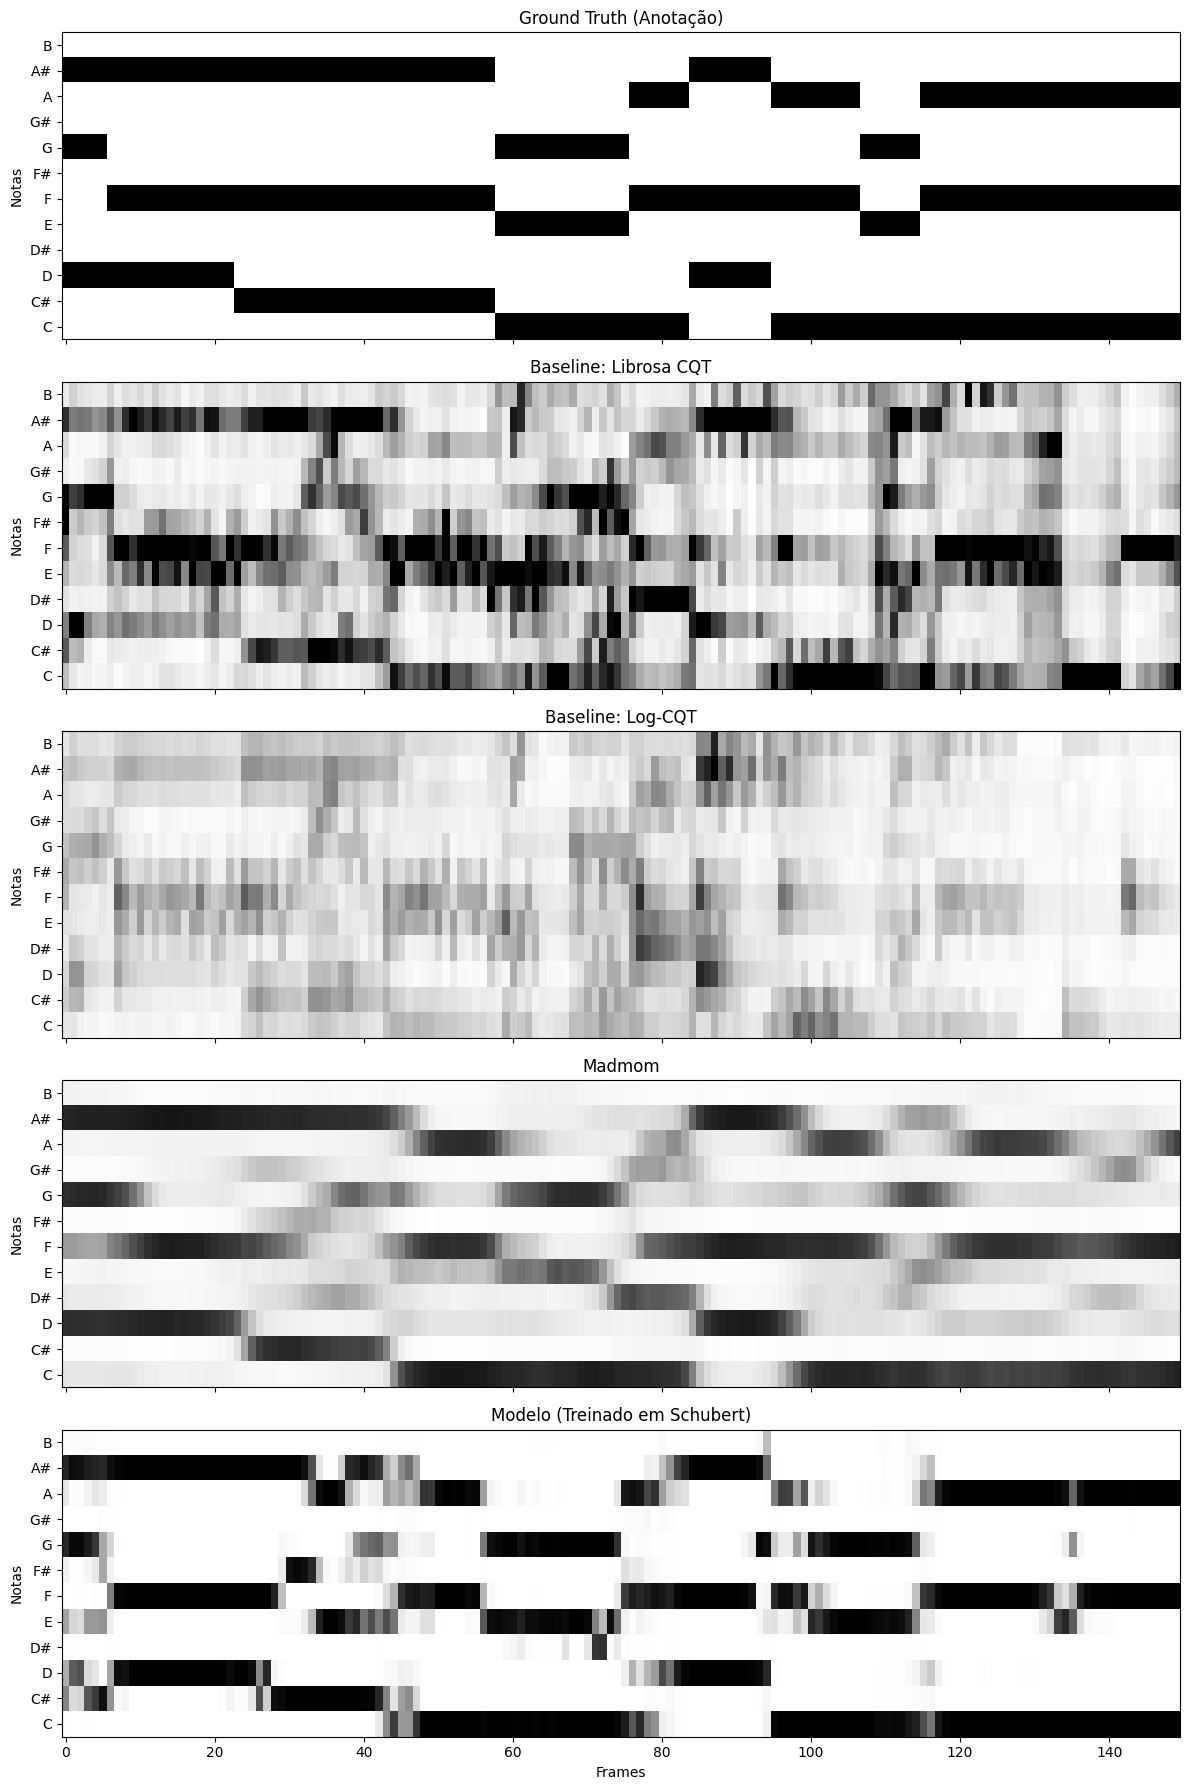

In [16]:
# 1. Carregar Modelo Treinado
print(f"Carregando modelo de: {MODEL_PATH}")
model = load_model(MODEL_PATH)

all_files = sorted([f.replace('.wav', '') for f in os.listdir(AUDIO_DIR) if f.endswith('.wav')])
test_files = all_files[-4:] # As mesmas 4 músicas de teste

# 3. Extrair
results = extract_all_features_comparison(test_files, AUDIO_DIR, ANNOT_DIR, model)

# 4. Plotar
plot_ultimate_comparison(results, start=500, duration=150)

In [19]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def run_final_evaluation(results_data):
    print("--- INICIANDO AVALIAÇÃO COMPARATIVA (Regressão Logística) ---")
    
    # 1. Preparar o Ground Truth (Converter de Tríades 12D para Classes 1D)
    # Pegamos o índice da nota mais forte (Ex: C=0, C#=1...)
    # Se o vetor for tudo zero, argmax retorna 0 (podemos tratar como silêncio se quiser, mas aqui simplificamos)
    y_full = np.argmax(results_data['y_plot'], axis=1)
    
    # 2. Divisão de Treino e Teste (50% / 50%)
    # Usamos random_state fixo para que todos os métodos sejam testados nos mesmos frames
    idx_train, idx_test = train_test_split(
        np.arange(len(y_full)), 
        test_size=0.5, 
        random_state=42
    )
    
    y_train = y_full[idx_train]
    y_test = y_full[idx_test]
    
    # Lista de métodos para avaliar
    methods = ['C', 'C_log', 'Madmom', 'Deep']
    
    # Dicionário para guardar os resultados
    final_results = []

    for method in methods:
        if method not in results_data:
            continue
            
        print(f"Treinando classificador para: {method}...")
        
        # Pegar as features
        X = results_data[method]
        
        # Padronizar os dados (Importante para a Regressão convergir rápido)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X[idx_train])
        X_test = scaler.transform(X[idx_test])
        
        # Treinar o "Juiz" (Regressão Logística)
        # max_iter=1000 garante que ele tenha tempo de aprender
        clf = LogisticRegression(max_iter=1000, solver='lbfgs', C=0.1)
        clf.fit(X_train, y_train)
        
        # Avaliar
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        
        final_results.append({
            'Método': method,
            'Acurácia': f"{acc:.2%}",
            'Dimensões': X.shape[1]
        })

    # 3. Exibir a Tabela Bonita
    df_results = pd.DataFrame(final_results)
    print("\n" + "="*40)
    print("RESULTADO FINAL (Schubert Winterreise)")
    print("="*40)
    print(df_results)
    print("="*40)
    
    return df_results

# --- RODAR A TABELA ---
if 'results' in locals():
    df_tabela = run_final_evaluation(results)
else:
    print("Por favor, rode a extração (célula anterior) antes de gerar a tabela.")

--- INICIANDO AVALIAÇÃO COMPARATIVA (Regressão Logística) ---
Treinando classificador para: C...
Treinando classificador para: C_log...
Treinando classificador para: Madmom...
Treinando classificador para: Deep...

RESULTADO FINAL (Schubert Winterreise)
   Método Acurácia  Dimensões
0       C   84.67%         12
1   C_log   77.26%         12
2  Madmom   90.95%         12
3    Deep   87.61%         12
